# Double DQN - Pendulum-v1

In [2]:
import gymnasium as gym
print(gym.__version__)   #1.1.1
import random
import numpy as np
import collections
from tqdm.notebook import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

1.1.1


In [3]:
env_name = 'Pendulum-v1'
env = gym.make(env_name)

# Double DQN

In [4]:
class ReplayBuffer:
    ''' 经验回放池 '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):
        return len(self.buffer)

In [5]:
class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        return self.fc2(x)

In [6]:
class DQN:
    '''DQN算法,包括Double DQN ，其中dqn_type可以设置为'VanillaDQN'普通DQN或者'DoubleDQN'。Vanilla普通的'''
    def __init__(self,state_dim,hidden_dim,action_dim,learning_rate,gamma,epsilon,target_update,device,
                 dqn_type='VanillaDQN'):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
        self.target_q_net = Qnet(state_dim, hidden_dim,self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.dqn_type = dqn_type
        self.device = device

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.from_numpy(state).float().to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def max_q_value(self, state):  #不参与训练，只是用来记录和监控。
        state = torch.from_numpy(state).float().to(self.device)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.from_numpy(transition_dict['states']).float().to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.from_numpy(transition_dict['next_states']).float().to(self.device)
        dones = torch.tensor(transition_dict['dones'],dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)  # Q值

        # 下个状态的最大Q值
        if self.dqn_type == 'DoubleDQN': # DQN与Double DQN的区别
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1)  #取出使得q最大对应的动作索引
            max_next_q_values = self.target_q_net(next_states).gather(1, max_action)
            # 把next_states传入传入的target_q_net，得到q,但是不是直接选最大的q,而是根据上一步得到的索引选q
        else:
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        '''
        所以普通DQN和Double DQN的区别就在于：
        普通DQN是把next_states传入target_q_net，直接选出最大的q,
        Double DQN是把next_states传入q_net，得到使得q最大的动作，然后再把next_states传入target_q_net,得到q,但不是直接选最大的q,而是根据刚刚得到的动作，选择那个动作对应的q
        Double DQN核心：选择动作用在线网络，评估动作用目标网络
        '''
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)  # TD误差目标

        dqn_loss = F.mse_loss(q_values, q_targets) # 均方误差损失函数
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(
                self.q_net.state_dict())  # 更新目标网络
        self.count += 1

In [7]:
def dis_to_con(discrete_action, env, action_dim):  # 离散动作转回连续的函数
    action_lowbound = env.action_space.low[0]      # 连续动作的最小值，获得环境的动作的界限
    action_upbound = env.action_space.high[0]      # 连续动作的最大值
    return action_lowbound + (discrete_action /(action_dim - 1)) * (action_upbound -action_lowbound)

# 训练函数

In [8]:
def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size,batch_size):
    return_list = []
    max_q_value_list = []
    max_q_value = 0
    for i in range(10):
        with tqdm(total=int(num_episodes / 10),desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                state , info = env.reset(seed=0)  #state是二维np.array
                done = False
                while not done:
                    action = agent.take_action(state)
                    # 之前离散动作的环境直接next_state, reward, terminated, truncated, info = env.step(action)
                    max_q_value = agent.max_q_value(state) * 0.005 + max_q_value * 0.995  # 平滑处理
                    max_q_value_list.append(max_q_value)  # 保存每个状态的最大Q值

                    action_continuous = dis_to_con(action, env,agent.action_dim)
                    # action对应动作索引0-10，agent.action_dim=11
                    # 要把这个动作的索引转成实际的值，传进去比如第0个动作就是-2，第1个动作是-1.6。
                    next_state, reward, terminated, truncated, info = env.step([action_continuous])
                    done = terminated or truncated  # terminated和truncated得到值为True或Fasle
                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                        # b_s,b_ns是二维np.aarray,其他是元组，查看replay_buffer.sample()源码
                        transition_dict = {'states': b_s,'actions': b_a,'next_states': b_ns,
                                           'rewards': b_r,'dones': b_d }
                        agent.update(transition_dict)
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({'episode':'%d' % (num_episodes / 10 * i + i_episode + 1),'return':'%.3f' % np.mean(return_list[-10:])})
                pbar.update(1)
    return return_list, max_q_value_list

# 训练

## 实例化

In [9]:
buffer_size = 50000
replay_buffer_vanilla = ReplayBuffer(buffer_size)
replay_buffer_double= ReplayBuffer(buffer_size)
#===================================================
state_dim = env.observation_space.shape[0]
hidden_dim = 128
action_dim = 11  # 将连续动作分成11个离散动作
lr = 1e-2
gamma = 0.98
epsilon = 0.01
target_update = 50
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

agent_vanilla = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,target_update, device)
agent_double = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,target_update, device,'DoubleDQN')

minimal_size = 5000
batch_size = 64
num_episodes = 500

## 开始训练Vanilla DQN

In [10]:
return_list_Vanilla, max_q_value_list_Vanilla = train_DQN(agent_vanilla, env, num_episodes,replay_buffer_vanilla, minimal_size,batch_size)

Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration 1:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration 2:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration 3:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration 4:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration 5:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration 6:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration 7:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration 8:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration 9:   0%|          | 0/50 [00:00<?, ?it/s]

## Vanilla DQN训练结束

## 开始训练Double DQN

In [11]:
return_list_Double, max_q_value_list_Double = train_DQN(agent_double, env, num_episodes,replay_buffer_double, minimal_size,batch_size)

Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration 1:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration 2:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration 3:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration 4:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration 5:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration 6:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration 7:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration 8:   0%|          | 0/50 [00:00<?, ?it/s]

Iteration 9:   0%|          | 0/50 [00:00<?, ?it/s]

## Double DQN训练结束

## 保存网络

In [12]:
torch.save(agent_double.q_net.state_dict(), 'double_dqn_pendulum_q_net.pth')
# 保存主网络

## 训练过程可视化

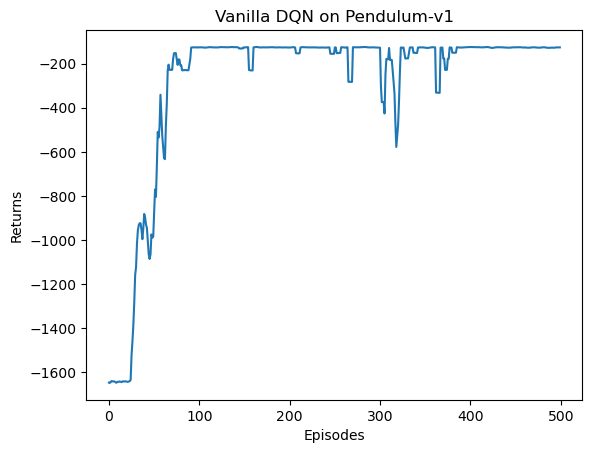

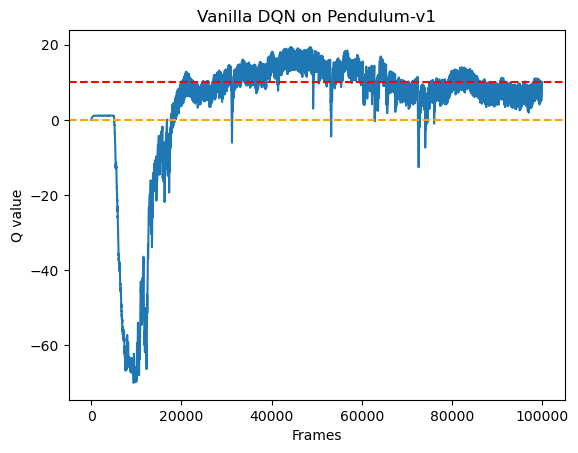

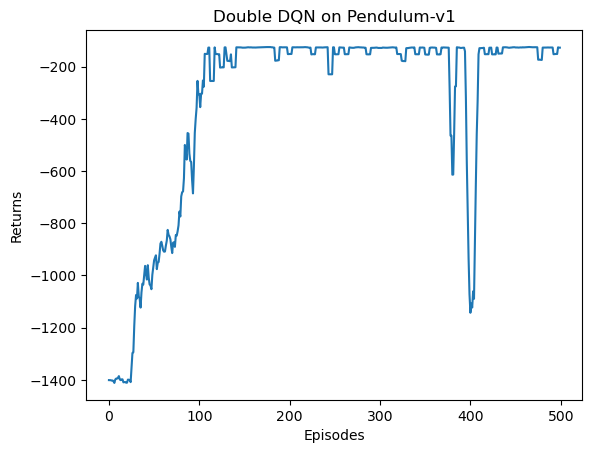

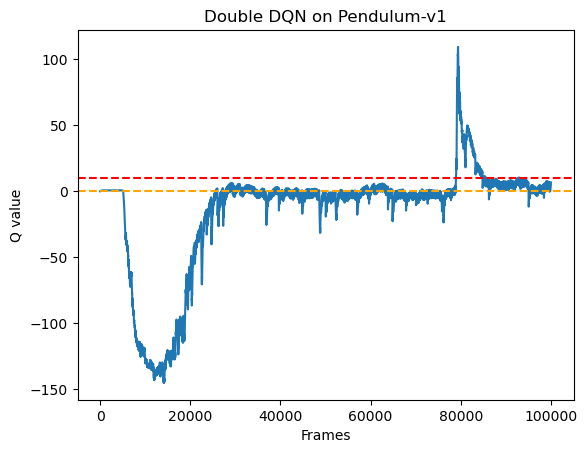

In [13]:
def moving_average(x, window):
    x = np.array(x, dtype=float)
    ma = np.zeros_like(x)  # 存放结果
    for i in range(len(x)):
        start = max(0, i - window + 1)
        end = i + 1
        ma[i] = x[start:end].mean()   # 只用窗口内现有元素求平均
    return ma

episodes_list = list(range(len(return_list_Vanilla)))
ma = moving_average(return_list_Vanilla, 5)
plt.plot(episodes_list, ma)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Vanilla DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list_Vanilla)))
plt.plot(frames_list, max_q_value_list_Vanilla)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Vanilla DQN on {}'.format(env_name))
plt.show()

episodes_list = list(range(len(return_list_Double)))
ma = moving_average(return_list_Double, 5)
plt.plot(episodes_list, ma)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Double DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list_Double)))
plt.plot(frames_list, max_q_value_list_Double)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Double DQN on {}'.format(env_name))
plt.show()

# Q值高估

根据pendulum-v1的奖励函数和Q(s,a),实际的Q值是小于0的,但是如图,出现了Q值大于0的情况,是因为神经网络拟合的误差通常会出现某些动作的估算有正误差的情况。
<br>Double DQN可以改善这种情况。对比查看上图。(出现了一个意外，Double DQN怎么有一个那么大的Q)